In [11]:
import numpy as np
import os
from solver_funcs import F_operator, mu_from_params
import matplotlib.pyplot as plt
from utils import noise_addition_image

from posterior_funcs import Posterior, MuVector, Prior

## HYPERPARAMETERS

In [3]:
sigma_percentage = 1.0
directory = f"results_{int(sigma_percentage*100)}percentnoise"

if not os.path.exists(directory):
    os.makedirs(directory)

## DEFINE TARGET MEASUREMENT

In [4]:
def get_y(mu_vect):
    mu, y = F_operator(mu_vect.vector)
    mask = mu != 100
    mask = mask.astype(int)
    mask = np.repeat(mask, 2, axis=3)
    y = np.multiply(y, mask)
    return mu, y

/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  (self.LC_y_3 - self.LC_y_2) / (self.LC_x_3 - self.LC_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  (self.LC_y_4 - self.LC_y_1) / (self.LC_x_4 - self.LC_x_1),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:220: RuntimeWarning: divide by zero encountered in scalar divide
  (self.SCTL_y_3 - self.SCTL_y_2) / (self.SCTL_x_3 - self.SCTL_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:486: RuntimeWarning: divide by zero encountered in scalar divide
  (self.ULC_y_3 - self.ULC_y_2) / (self.ULC_x_3 - self.ULC_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.639e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.433e-17 (tol = 1.000e-10) r (rel) = 5.132e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


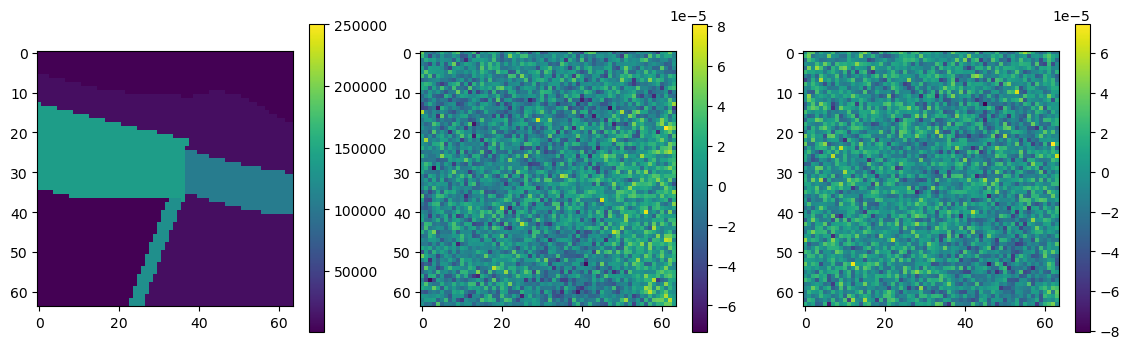

In [5]:
mu_vect = MuVector()
a = mu_vect.sample_vector()

mu, y = get_y(mu_vect)
sigma = y.max()*sigma_percentage
meas_y = noise_addition_image(y, noise_level=sigma)
np.save(directory + '/sigma.npy', np.array(y.max()*0.75))
np.save(directory + '/meas_y.npy', meas_y)
np.save(directory + '/mu_vect.npy', mu_vect.get_vector())

fig, ax = plt.subplots(1,3, figsize=(14,4))

cb=ax[0].imshow(mu[0,:,:,0], vmax=250000)
plt.colorbar(cb, ax=ax[0])
cb=ax[1].imshow(meas_y[0,:,:,0])
plt.colorbar(cb, ax=ax[1])
cb=ax[2].imshow(meas_y[0,:,:,1])
plt.colorbar(cb, ax=ax[2])

## SAMPLING ALGORITHM - Posterior

In [7]:
sigma = np.load(directory + '/sigma.npy')
meas_y = np.load(directory + '/meas_y.npy')

chain = []

posterior = Posterior(sigma)
mu_vect = MuVector()
_ = mu_vect.sample_vector()
mu_cur = mu_vect.get_vector_4dim()

n_steps = 5000
epsilon = 4e-2
factors = [1, 2, 4, 1]
n_accepted = 0

y_cur = get_y(mu_vect)[1]
p_cur = posterior.logpostprob(mu_cur, y_cur, meas_y)
chain.append(mu_cur)

for i in range(n_steps):
    mu_prop = mu_cur + mu_vect.get_step(epsilon, factors)
    mu_vect.update_vector(mu_prop)
    y_prop = get_y(mu_vect)[1]
    p_prop = posterior.logpostprob(mu_prop, y_prop, meas_y)
    alpha = min(1, np.exp(p_prop - p_cur))
    u = np.random.uniform()
    if i % 10 == 0:
        print(f"alpha: {alpha}; u: {u}, p_prop: {p_prop}, p_cur: {p_cur}")
    if u < alpha:
        mu_cur = mu_prop
        p_cur = p_prop
        n_accepted += 1
    
    chain.append(mu_cur)

    if i % 10 == 0:
        print(f"Iteration: {i}; Acceptance rate: {n_accepted/(i+1)}")
        print(f"Current mu: {mu_vect.get_vector_4dim()}")


chain = np.array(chain)
np.save(directory + '/chain.npy', chain)

/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  (self.LC_y_3 - self.LC_y_2) / (self.LC_x_3 - self.LC_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  (self.LC_y_4 - self.LC_y_1) / (self.LC_x_4 - self.LC_x_1),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:220: RuntimeWarning: divide by zero encountered in scalar divide
  (self.SCTL_y_3 - self.SCTL_y_2) / (self.SCTL_x_3 - self.SCTL_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/ONHFenics_SamplingPosterior/mu_funcs_given.py:486: RuntimeWarning: divide by zero encountered in scalar divide
  (self.ULC_y_3 - self.ULC_y_2) / (self.ULC_x_3 - self.ULC_x_2),
/Users/javiermurgoitioesandi/Desktop/WIP/CWGAN_InverseElast/

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.107e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.127e-17 (tol = 1.000e-10) r (rel) = 4.532e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.241e-03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.190e-17 (tol = 1.000e-10) r (rel) = 4.534e-15 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
alpha: 0.0005346300369071823; u: 0.12304987993764804, p_prop: -7428.839348237339, p_cur: -7421.305412667261
Iteration: 0; Acceptance rate: 0.0

KeyboardInterrupt: 

## CHECKING CHAIN

In [12]:
sigma_percentage = 1.0
directory = f"results_{int(sigma_percentage*100)}percentnoise"

In [13]:
true_mu = np.load(directory + '/mu_vect.npy')
# true_mu_vect = MuVector()
# true_mu_vect.update_vector(true_mu)
# true_mu = true_mu_vect.get_vector_4dim()
chain = np.load(directory + '/chain.npy')

In [14]:
true_mu

array([ 5.85871871e-01,  2.45000000e+00,  2.70000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.75000000e+00,  0.00000000e+00,  2.75000000e+00,
        3.00000000e+00,  0.00000000e+00,  6.00000000e-02, -6.00000000e-02,
        6.00000000e-01,  1.00000000e-01,  8.00000000e-01,  1.20000000e+01,
        1.00000000e+00,  3.00000000e-01,  3.00000000e-01,  1.00000000e-01,
        7.50000000e-01,  7.50000000e-01,  1.50000000e+01,  1.50000000e+01,
        8.00000000e-02,  8.00000000e-02,  1.17370928e+05,  7.18591408e+04,
        9.80000000e+03,  9.80000000e+03,  9.80000000e+03,  1.25000000e+05,
        1.77551883e-01])

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        9.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+0

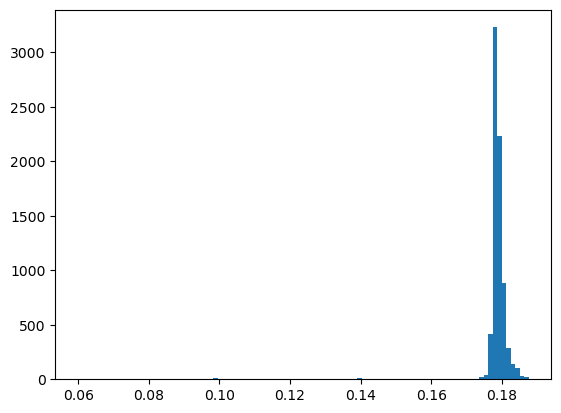

In [21]:
plt.hist(chain[:,3], bins=100)

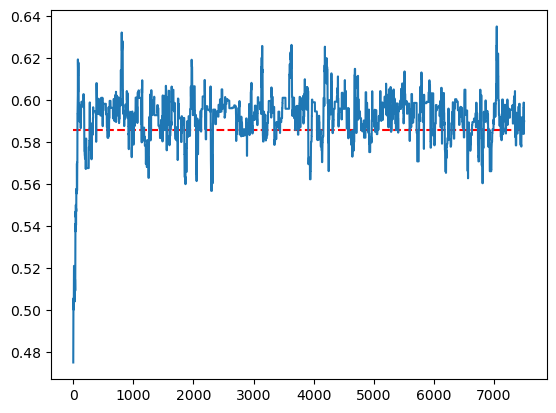

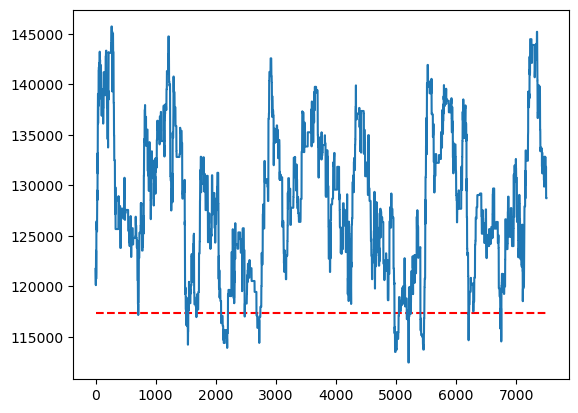

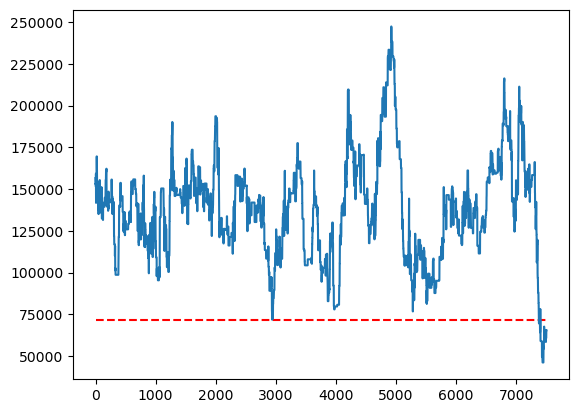

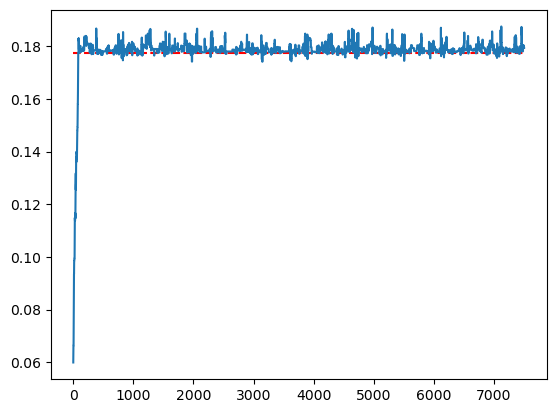

In [16]:
plt.plot([0,chain.shape[0]],[true_mu[0],true_mu[0]],'r--')
plt.plot(chain[:,0])
plt.show()
plt.plot([0,chain.shape[0]],[true_mu[26],true_mu[26]],'r--')
plt.plot(chain[:,1])
plt.show()
plt.plot([0,chain.shape[0]],[true_mu[27],true_mu[27]],'r--')
plt.plot(chain[:,2])
plt.show()
plt.plot([0,chain.shape[0]],[true_mu[32],true_mu[32]],'r--')
plt.plot(chain[:,3])
plt.show()

## SAMPLING ALGORITHM - Prior

In [15]:
chain = []

prior = Prior()
mu_vect = MuVector()
_ = mu_vect.sample_vector()
mu_cur = mu_vect.get_vector_4dim()

n_steps = 50000
epsilon = 1e-1
n_accepted = 0

p_cur = prior.logprob(mu_cur)

for i in range(n_steps):
    mu_prop = mu_cur + mu_vect.get_step(epsilon)
    p_prop = prior.logprob(mu_prop)
    
    alpha = min(1, np.exp(p_prop - p_cur))
    u = np.random.uniform()
    if i % 10000 == 0:
        print(f"alpha: {alpha}; u: {u}, p_prop: {p_prop}, p_cur: {p_cur}")
    if u < alpha:
        mu_cur = mu_prop
        p_cur = p_prop
        n_accepted += 1
    
    chain.append(mu_cur)

    if i % 10000 == 0:
        print(f"Iteration: {i}; Acceptance rate: {n_accepted/(i+1)}")


chain = np.array(chain)

alpha: 1; u: 0.6148034894363335, p_prop: -0.7522762573275159, p_cur: -0.9526584583217472
Iteration: 0; Acceptance rate: 1.0
alpha: 0.0; u: 0.47124394966152405, p_prop: -inf, p_cur: -0.23642833660337112
Iteration: 10000; Acceptance rate: 0.7992200779922007
alpha: 1; u: 0.12339512867474622, p_prop: -0.2463985270117903, p_cur: -0.2505554857088735
Iteration: 20000; Acceptance rate: 0.7989100544972751
alpha: 0.9313910049274413; u: 0.4802254060042348, p_prop: -0.7240878088482159, p_cur: -0.6530117027849867
Iteration: 30000; Acceptance rate: 0.7966401119962668
alpha: 0.8380101826416244; u: 0.8402093783045407, p_prop: -2.6107595889050166, p_cur: -2.434034561454795
Iteration: 40000; Acceptance rate: 0.7982050448738781


(array([3255., 5580., 7187., 9136., 8496., 7568., 5449., 3329.]),
 array([3.57986326e+01, 1.83047937e+04, 3.65737888e+04, 5.48427839e+04,
        7.31117789e+04, 9.13807740e+04, 1.09649769e+05, 1.27918764e+05,
        1.46187759e+05]),
 <BarContainer object of 8 artists>)

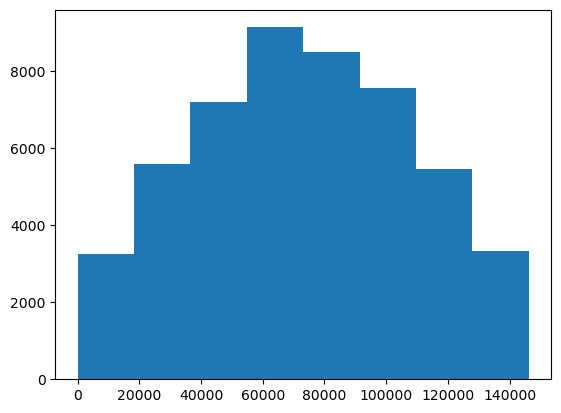

In [ ]:
plt.hist(chain[:,1], bins=8, density=True)

In [45]:
-0.5*np.power(np.random.normal(0, 1, 64*64*2),2).sum()

-4032.449402365195